In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>"))
plotwidth = 40

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import yaml
import json
from tqdm.notebook import tqdm, trange
import time
import os
import sys
import netrc
#import psycopg2

# Globals

In [4]:
# Source of inspiration from covariatns, see:
# https://github.com/hodcroftlab/covariants/blob/master/web/data/clusters.json
#
# Keep in sync with covspectrum, see:
# https://github.com/GenSpectrum/cov-spectrum-website/blob/develop/src/models/wasteWater/constants.ts
color_map = {
    'BA.2.86': '#FF20E0',
    "XBB.1.5": "#ff5656",
    "undetermined": "#969696"
}

In [5]:
### Input
# directory where V-pipe was run
datadir = "./results/"


#### Output
plots_dir = "./results/plots/"  # for graphics files
outdir = "./results/"  # for data output

In [6]:
# Load data to be uploaded
jsonfile_smooth = os.path.join(datadir, "deconvoluted_upload.json")
# 'all_bootstrap_upload.json') # 'basel_upload.json') #"lausanneupdate.json") # all_upload.json")

# backup the combined data
update_data_combined_file = os.path.join(outdir, "ww_update_data_combined.json")
reformatted = "/tmp/ww_update_data_smooth_kernel_rob.json"

# Data

In [7]:
# Smoothed curves
print(
    f"reusing {jsonfile_smooth} last modified: {time.ctime(os.path.getmtime(jsonfile_smooth))}"
)

with open(jsonfile_smooth, "r") as file:
    update_data_smooth = json.load(file)

reusing ./results/deconvoluted_upload.json last modified: Thu Mar  7 09:06:39 2024


In [8]:
# Locations list in smooth
locations_file = list({c for c in update_data_smooth.keys()})
", ".join(locations_file)

'schanf, davos'

In [9]:
# Date max (useful for the e-mail)
for l in locations_file:
    print(
        l,
        max(
            [
                d["date"]
                for v in update_data_smooth[l].values()
                for d in v["timeseriesSummary"]
            ]
        ),
        sep="\t",
    )

schanf	2024-01-24
davos	2024-01-24


In [10]:
# this next line clips the plots from a given date
# used for cities which don't want report before a given date
# or for variants that we only report after a given date
#only_start_from = {
#    "Kanton Zürich": "2021-08-15",  # start_date
#    # 'B.1.1.529':'2021-10-05',
#}
only_start_from = {}

update_data = {}
# HACK presume that the smoothing data is the exact set that we want to upload
locations_upload = locations_file
variants_upload = sorted(
    list({v for c in update_data_smooth.values() for v in c.keys()})
)
for loc in tqdm(locations_upload, desc="Locations", position=0):
    update_data[loc] = {}
    for var in tqdm(variants_upload, desc=loc, position=1, leave=False):
        # NOTE we always junk the heatmap, it's not up to date anyway
        update_data[loc][var] = {
            # "updateDate": todaydate,
            "timeseriesSummary": [
                x
                for x in update_data_smooth[loc][var]["timeseriesSummary"]
                if ((loc not in only_start_from) or (x["date"] >= only_start_from[loc]))
                and (
                    (var not in only_start_from) or (x["date"] >= only_start_from[var])
                )
            ],
            "mutationOccurrences": (np.nan),
        }

Locations:   0%|          | 0/2 [00:00<?, ?it/s]

schanf:   0%|          | 0/3 [00:00<?, ?it/s]

davos:   0%|          | 0/3 [00:00<?, ?it/s]

# Inspect

In [11]:
# Locations list in smooth
locations = sorted(list({c for c in update_data.keys()}))
", ".join(locations)

'davos, schanf'

In [12]:
# Variants in smooth

variants = sorted(list({v for c in update_data.values() for v in c.keys()}))
", ".join(variants)

'BA.2.86, XBB.1.5, undetermined'

In [13]:
# Does each one of them has a color?
missing_color = list(set(variants) - set(color_map.keys()))
print(", ".join(missing_color))
assert 0 == len(missing_color), "ERROR: some variant without color !"

In [14]:
# Load in a dataframe
df = pd.DataFrame.from_records(
    data=[
        {
            "location": loc,
            "date": pd.to_datetime(d["date"]),
            "variant": var,
            "proportion": d["proportion"],
            "upper": d["proportionUpper"],
            "lower": d["proportionLower"],
        }
        for loc in tqdm(locations_upload, desc="Locations", position=0)
        for var in tqdm(variants_upload, desc=loc, position=1, leave=False)
        for d in update_data_smooth[loc][var]["timeseriesSummary"]
    ]
)
df

Locations:   0%|          | 0/2 [00:00<?, ?it/s]

schanf:   0%|          | 0/3 [00:00<?, ?it/s]

davos:   0%|          | 0/3 [00:00<?, ?it/s]

,location,date,variant,proportion,upper,lower
0,schanf,2024-01-08,BA.2.86,0.711930,0.983242,4.978487e-01
1,schanf,2024-01-10,BA.2.86,0.982957,0.997561,9.313766e-01
2,schanf,2024-01-15,BA.2.86,0.996193,0.998556,9.900148e-01
3,schanf,2024-01-16,BA.2.86,0.987701,0.997162,9.524175e-01
4,schanf,2024-01-17,BA.2.86,0.942911,0.994346,8.532999e-01
5,schanf,2024-01-18,BA.2.86,0.998557,0.999467,9.971856e-01
6,schanf,2024-01-19,BA.2.86,0.997330,0.998811,9.944259e-01
7,schanf,2024-01-22,BA.2.86,0.984464,0.996071,9.483486e-01
8,schanf,2024-01-24,BA.2.86,0.990389,0.996686,9.784643e-01
9,schanf,2024-01-08,XBB.1.5,0.075447,0.203727,2.694843e-03


In [15]:
df.to_csv(os.path.join(outdir,'prevalence.csv'))

In [16]:
df.dtypes

location              object
date          datetime64[ns]
variant               object
proportion           float64
upper                float64
lower                float64
dtype: object

# Plot

Locations:   0%|          | 0/2 [00:00<?, ?it/s]

davos:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

schanf:   0%|          | 0/3 [00:00<?, ?it/s]

C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ale\anaconda3\envs\SIAF\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert in

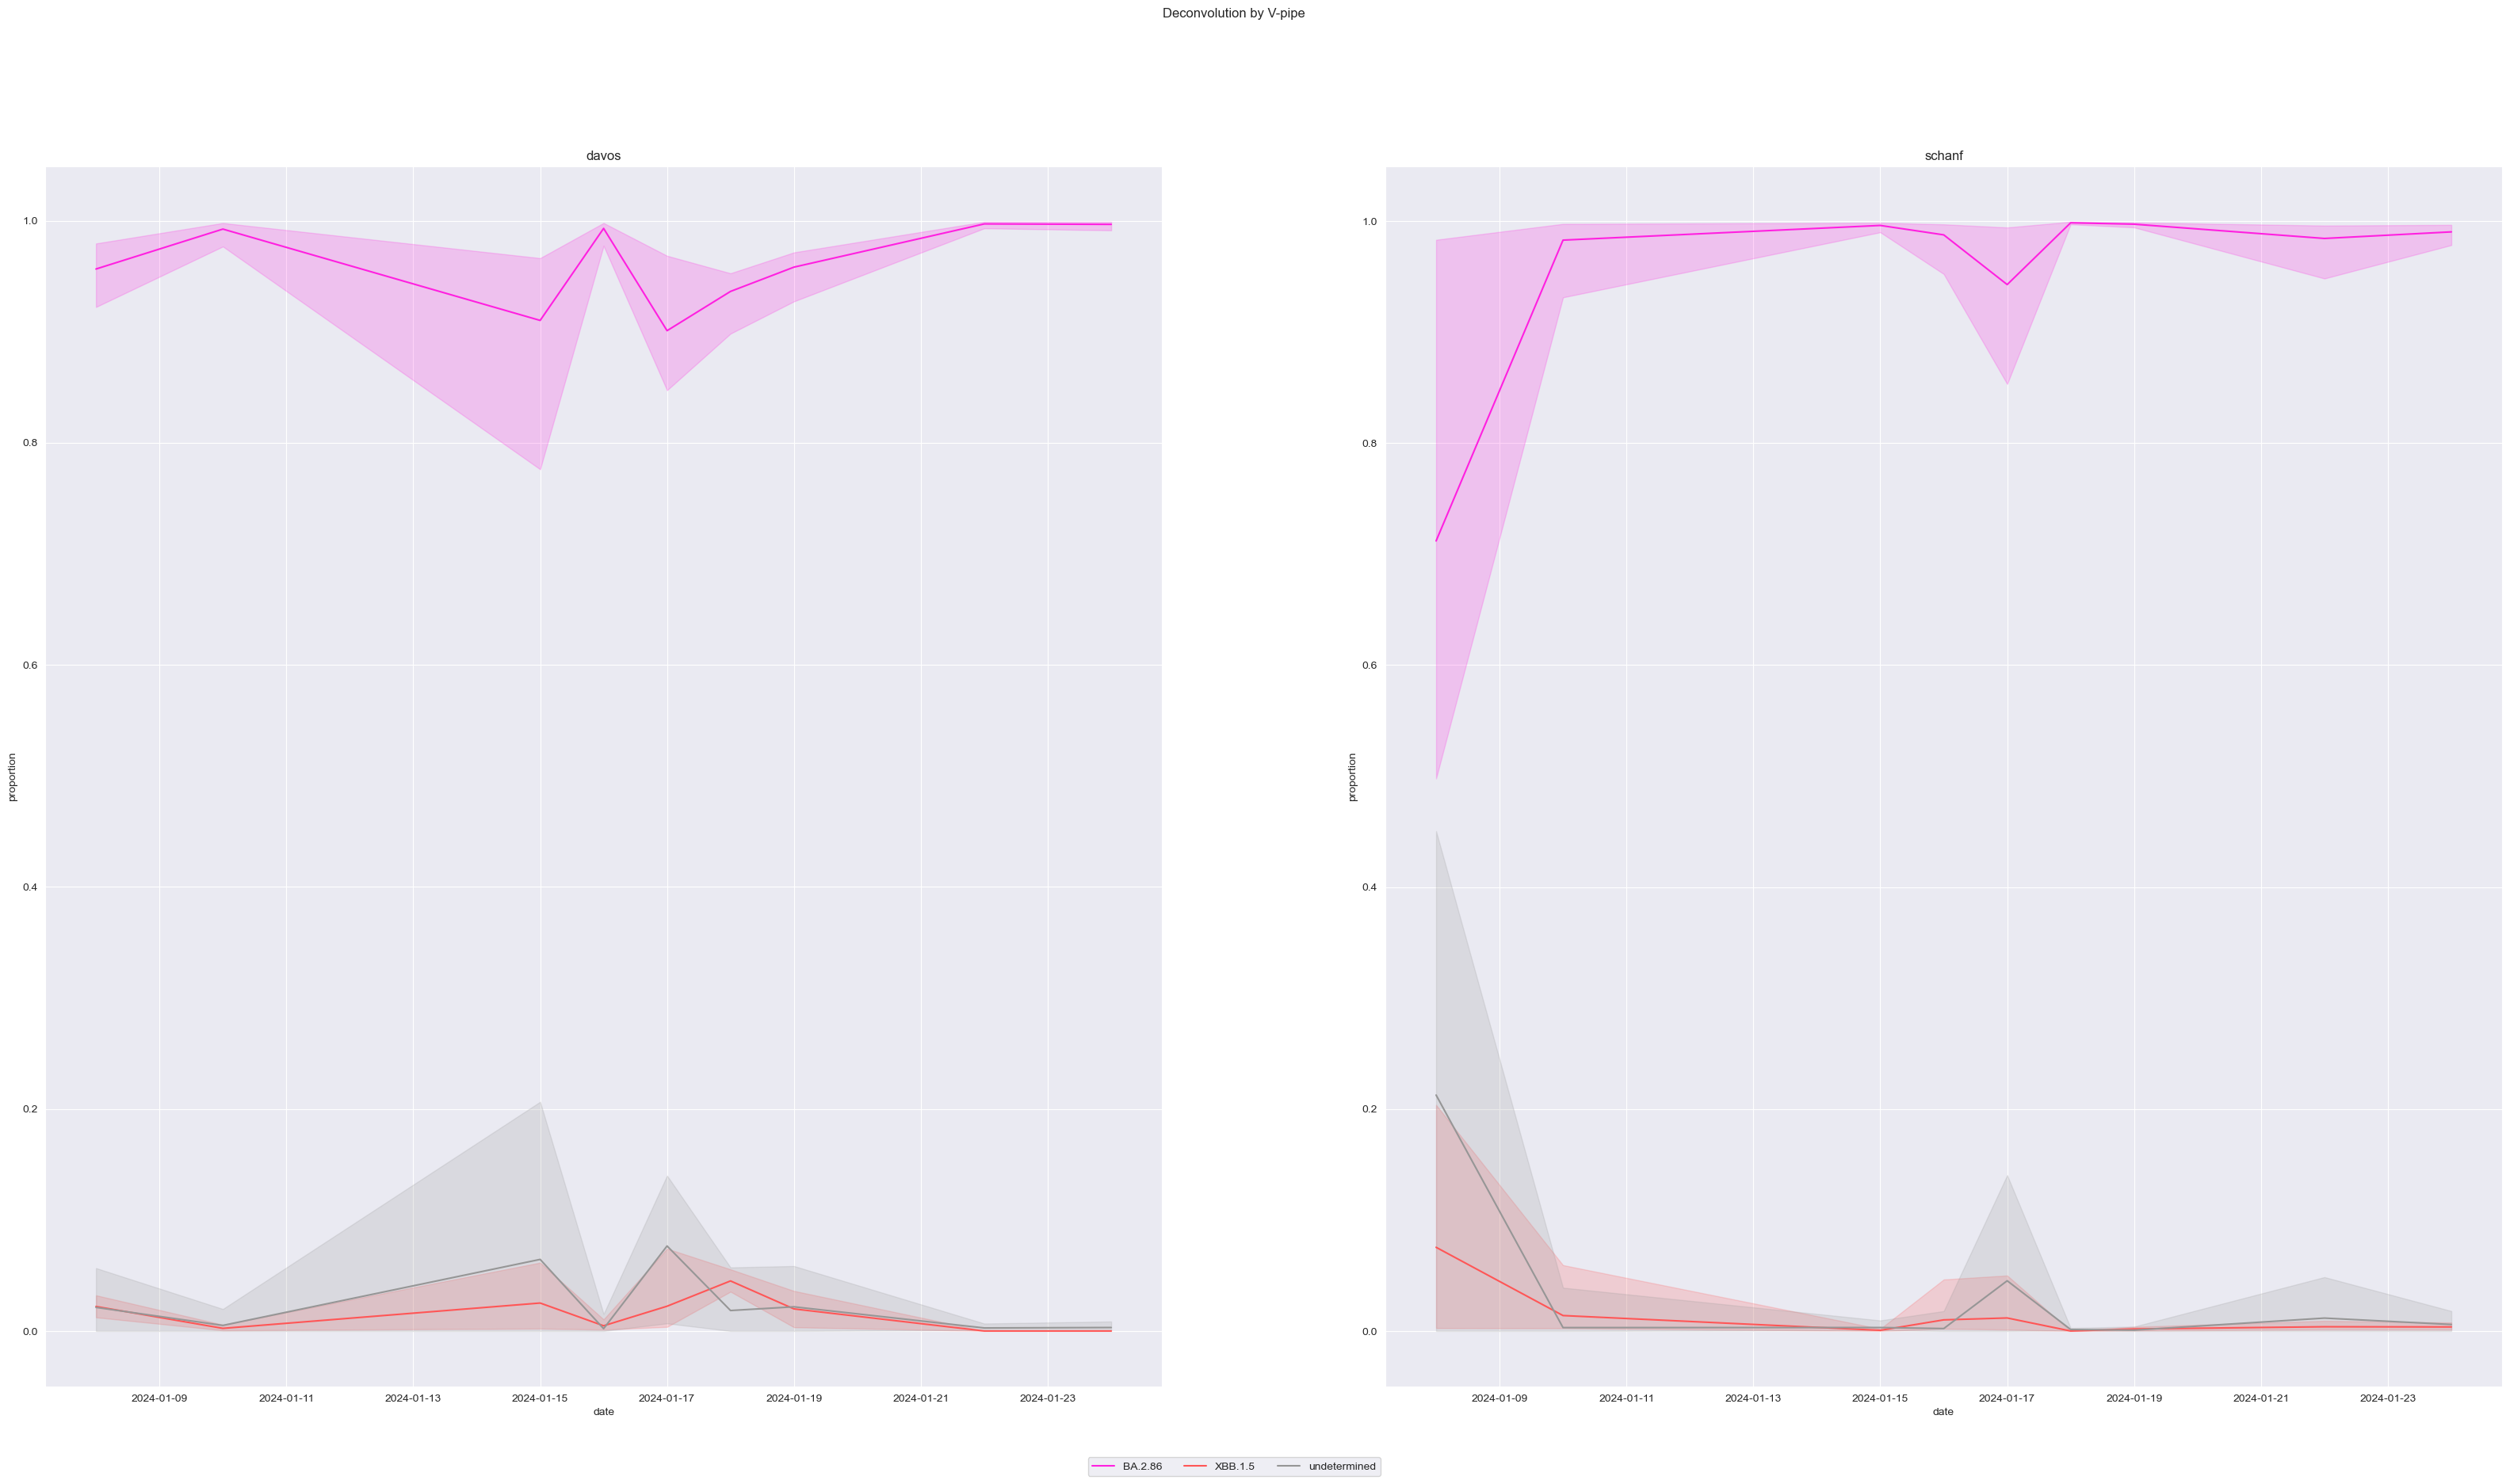

In [17]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(plotwidth, plotwidth / 2), sharex=True
)
axes = axes.flatten()

for i, loc in enumerate(tqdm(locations, desc="Locations", position=0, leave=False)):
    axes[i].set_title(loc)

    for var in tqdm(variants, desc=loc, position=1, leave=False):
        tt_df = df[(df["variant"] == var) & (df["location"] == loc)].sort_values(
            by=["date"]
        ).fillna(0)
        if tt_df.size == 0:
            continue
        g = sns.lineplot(
            x=tt_df["date"],
            y=tt_df["proportion"],
            hue=tt_df["variant"],
            ax=axes[i],
            palette=color_map,
        )
        g.get_legend().remove()
        axes[i].fill_between(
            x=tt_df["date"],
            y1=np.clip(tt_df["upper"], 0.0, 1.0),
            y2=np.clip(tt_df["lower"], 0.0, 1.0),
            alpha=0.2,
            # color="grey",
            color=color_map[var],
        )
handles, labels = axes[i].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="lower center", ncol=len(labels), bbox_to_anchor=(0.5, 0.05)
)
fig.suptitle(f"Deconvolution by V-pipe")
plt.savefig(os.path.join(plots_dir, f"combined-vpipe.pdf"))

# Upload

In [ ]:
with open(update_data_combined_file, "w") as file:
    file.write(
        json.dumps(update_data).replace("NaN", "null")
    )  # syntactically standard compliant JSON vs. python numpy's output.

## Upload to Cov-Spectrum

In [ ]:
dbhost = (
    "db-lapis.cuupxsogkmvx.eu-central-1.rds.amazonaws.com"  #'id-hdb-psgr-cp61.ethz.ch'
)

In [ ]:
# load from netrc
dbuser, dbpass = netrc.netrc().authenticators(dbhost)[0::2]

# alternative: input box
# dbuser = input(f"Enter username for database {dbhost}:\n")
# dbpass = input(f"Enter password for user {dbuser}:\n")

# alternative: enviro
# dbuser = os.environ['DB_USERNAME'],
# dbpass = os.environ['DB_PASSWORD'],

dbuser

In [ ]:
dbconn = psycopg2.connect(
    host=dbhost,
    database="covspectrum",  #'sars_cov_2',
    user=dbuser,
    password=dbpass,
    port="5432",
)
dbconn

In [ ]:
cur = dbconn.cursor()
cur

In [ ]:
for loc in tqdm(locations, desc="Locations", position=0):
    for pango in tqdm(variants, desc=loc, position=1, leave=True):
        cur.execute(
            """
            DO $$
            BEGIN
             IF EXISTS (SELECT ww.data FROM public.wastewater_result AS ww WHERE ww.variant_name=%(var)s AND ww.location=%(city)s) THEN
              UPDATE public.wastewater_result AS ww SET data=%(data)s WHERE ww.variant_name=%(var)s AND ww.location=%(city)s;
             ELSE
              INSERT INTO public.wastewater_result (variant_name, location, data)
              VALUES(%(var)s, %(city)s, %(data)s);
             END IF;
            END
            $$
            """,
            {
                "data": json.dumps(update_data[loc][pango]).replace("NaN", "null"),
                "var": pango,
                "city": loc,
            },
        )

### Multiple-choice time:

In [ ]:
## Abort DB update !
dbconn.rollback()

In [ ]:
## Save to DB !
dbconn.commit()

In [ ]:
cur.close()
dbconn.close()

## Upload to FOPH/BAG's Polybox

In [ ]:
polybox_url = "https://bs-pangolin@polybox.ethz.ch/remote.php/dav/files/bs-pangolin/Shared/BAG-COWWID19/"

In [ ]:
reformat = {
    var: {
        loc: {"timeseriesSummary": update_data[loc][var]["timeseriesSummary"]}
        for loc in tqdm(locations, desc=pango, position=1, leave=False)
    }
    for pango in tqdm(variants, desc="Variants", position=0)
}

### only in Notebook version 7.0
# from IPython.display import JSON
# display(JSON(reformat))

reformat  # ww_update_data_smooth_kernel_rob.json

In [ ]:
with open(reformatted, "w") as file:
    file.write(
        json.dumps(reformat).replace("NaN", "null")
    )  # syntactically standard compliant JSON vs. python numpy's output.

In [ ]:
%%bash -s "$polybox_url" "$update_data_combined_file" "$reformatted"
ls -l "$2"
curl --netrc --upload-file "$2" "$1" 
curl --netrc --upload-file "$3" "$1"